In [1]:
# === IMPORTS ===
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Import reusable data preprocessing functions
from add_preprocessing import load_and_prepare_data, create_preprocessor

# === LOAD & PREPARE DATA ===
X, y = load_and_prepare_data("../Motor_vehicle_insurance_data.csv")
preprocessor = create_preprocessor(X)

# === MODEL PIPELINE WITH RANDOM FOREST ===
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
])

# === TRAIN-TEST SPLIT & TRAINING ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

# === EXPORT TRAINED MODEL ===
joblib.dump(model, "../models/random_forest_model.pkl")
print("✅ Random Forest model trained and saved as '../models/random_forest_model.pkl'")

c:\Users\garre\OneDrive\Desktop\CSE 2600\Final Project\cse2600-main\cse2600-main\model_codes\add_preprocessing.py:14: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, delimiter=delimiter)


✅ Random Forest model trained and saved as '../models/random_forest_model.pkl'


c:\Users\garre\OneDrive\Desktop\CSE 2600\Final Project\cse2600-main\cse2600-main\model_codes\add_preprocessing.py:14: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, delimiter=delimiter)


✅ Model Evaluation
------------------------------
Accuracy: 0.8316991142058643
ROC AUC Score: 0.8389160092680372

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.32      0.44      4361
           1       0.84      0.97      0.90     16750

    accuracy                           0.83     21111
   macro avg       0.78      0.64      0.67     21111
weighted avg       0.82      0.83      0.81     21111



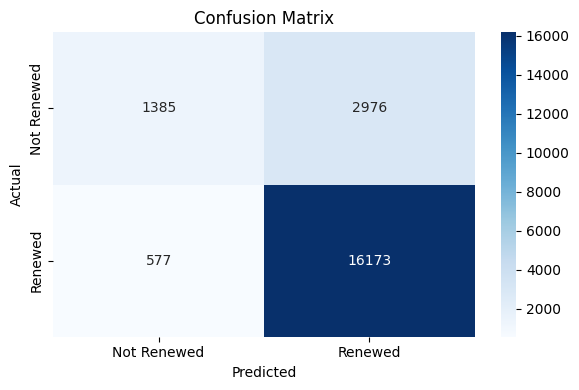

In [2]:
# === IMPORTS ===
import joblib
import pandas as pd
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# === LOAD RAW TEST DATA ===
# We need to recreate the test set like during training
from add_preprocessing import load_and_prepare_data

# Load dataset
X_full, y_full = load_and_prepare_data("../Motor_vehicle_insurance_data.csv")

# Split (IMPORTANT: same random_state)
from sklearn.model_selection import train_test_split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# === LOAD SAVED RANDOM FOREST MODEL ===
model = joblib.load("../models/random_forest_model.pkl")

# === PREDICT ON RAW TEST SET ===
y_pred = model.predict(X_test_raw)
y_prob = model.predict_proba(X_test_raw)[:, 1]  # Probabilities for ROC AUC

# === EVALUATE MODEL PERFORMANCE ===
print("✅ Model Evaluation")
print("-" * 30)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# === DISPLAY CONFUSION MATRIX ===
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=['Not Renewed', 'Renewed'],
            yticklabels=['Not Renewed', 'Renewed'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [ ]:
# === TRAINING ACCURACY ===
y_train_pred = model.predict(X_train_raw)
train_accuracy = accuracy_score(y_train, y_train_pred)

# === TEST ACCURACY ===
test_accuracy = accuracy_score(y_test, y_pred)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# === BIAS-VARIANCE ANALYSIS ===
if train_accuracy < 0.8 and test_accuracy < 0.8:
    print("The model may have high bias (underfitting).")
elif train_accuracy > 0.95 and test_accuracy < 0.8:
    print("The model may have high variance (overfitting).")
else:
    print("The model has a good balance between bias and variance.")

Training Accuracy: 0.987151248164464
Test Accuracy: 0.8316991142058643
The model has a good balance between bias and variance.


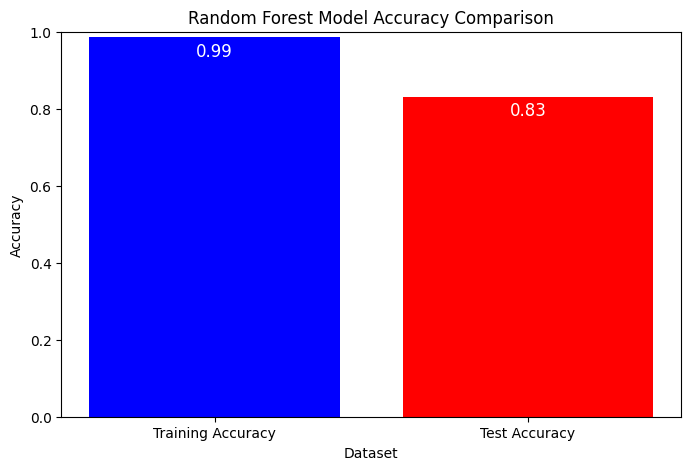

In [7]:
import matplotlib.pyplot as plt

# Data for the graph
accuracy_data = {'Training Accuracy': train_accuracy, 'Test Accuracy': test_accuracy}
labels = list(accuracy_data.keys())
values = list(accuracy_data.values())

# Plotting the bar chart
plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['blue', 'red'])
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.title('Random Forest Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Dataset')
plt.text(0, train_accuracy - 0.05, f"{train_accuracy:.2f}", ha='center', color='white', fontsize=12)
plt.text(1, test_accuracy - 0.05, f"{test_accuracy:.2f}", ha='center', color='white', fontsize=12)
plt.show()